In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons


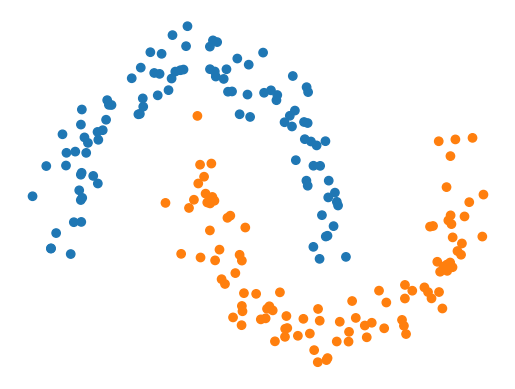

In [2]:

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [3]:
import pennylane as qml

In [4]:
print(X)

[[-1.04942573e+00  8.44426315e-02]
 [ 9.22817545e-01  4.57488507e-01]
 [ 6.56786593e-01  6.99596694e-01]
 [ 1.18894020e+00 -3.86528073e-01]
 [ 2.89264549e-01 -1.37744892e-01]
 [ 2.51685082e-01  1.81006054e-01]
 [-6.68120991e-01  8.22265447e-01]
 [ 1.55626644e+00 -2.03445580e-01]
 [ 1.87213538e+00 -1.25335230e-01]
 [ 1.43229273e-01  9.53267512e-01]
 [-4.35091327e-01  7.43738050e-01]
 [ 1.91161702e+00 -1.05146485e-01]
 [ 1.53432590e+00 -3.97547101e-01]
 [-8.24879535e-01  5.29607749e-01]
 [ 1.88043395e+00  1.54681644e-01]
 [ 1.87043050e+00 -9.01427936e-02]
 [-6.84180156e-02  1.23271872e+00]
 [ 1.04680086e+00 -5.17441448e-01]
 [-1.00198756e+00  6.32750117e-01]
 [-4.23980382e-01  7.45855239e-01]
 [ 3.38030046e-01 -6.83719318e-02]
 [ 8.96478204e-01  5.70936879e-01]
 [ 9.69901385e-01 -6.20552828e-01]
 [-8.76993958e-01  3.21761811e-01]
 [-3.98820968e-01  7.86003637e-01]
 [-4.02185906e-01  8.31958013e-01]
 [-8.11837713e-01  5.85065474e-01]
 [-4.84776843e-01  9.43778988e-01]
 [ 2.11761003e-01 -1

In [30]:


n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    out = [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    #print(qml.probs())
    #print(input , out)
    return out

In [31]:
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}

In [32]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [33]:
clayer_1 = torch.nn.Linear(2, 8)
clayer_2 = torch.nn.Linear(8, 2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

In [34]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

In [ ]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 6

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

In [ ]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 4)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(4, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 2, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

: 

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)
epochs = 6

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

: 

In [ ]:
a = torch.tensor([1,2,3])
b = torch.tensor([1,2])
print(a)
print(b)
qml.math.tensordot(a,b,0)

: 